In [1]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import accuracy_score
def my_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

In [3]:
data = pd.read_pickle('all_features.pkl')
print(data.shape)
data.tail(5)

(44188, 656)


p2_filter_lag_1_max_points_in_a_row_match__median_7  \
date       p1          p2                                                                 
2020-11-21 Medvedev D. Nadal R.                                                   5.0     
           Nadal R.    Medvedev D.                                                7.0     
           Thiem D.    Djokovic N.                                                7.0     
2020-11-22 Medvedev D. Thiem D.                                                   6.0     
           Thiem D.    Medvedev D.                                                7.0     

                                    p1_lag_1_points_won_match__pctl10_28  \
date       p1          p2                                                  
2020-11-21 Medvedev D. Nadal R.                                     47.4   
           Nadal R.    Medvedev D.                                  58.7   
           Thiem D.    Djokovic N.                                  60.2   
2020-11-22 Medvedev D. Thiem D.                                     47.4   
           Thiem D.    Medvedev D.                                  60.2   

                                    p1_lag_1_second_serve_prc_match__pctl90_7  \
date       p1          p2                                                       
2020-11-21 Medvedev D. Nadal R.                                      0.962500   
           Nadal R.    Medvedev D.                                   1.000000   
           Thiem D.    Djokovic N.                                   0.974286   
2020-11-22 Medvedev D. Thiem D.                                      0.932143   
           Thiem D.    Medvedev D.                                   0.962500   

                                    p2_lag_1_second_serve_cnt_match__median_28  \
date       p1          p2                                                        
2020-11-21 Medvedev D. Nadal R.                                           23.0   
           Nadal R.    Medvedev D.                                        18.0   
           Thiem D.    Djokovic N.                                        22.0   
2020-11-22 Medvedev D. Thiem D.                                           31.0   
           Thiem D.    Medvedev D.                                        18.0   

                                    p2_filter_lag_1_max_points_in_a_row_match__pctl10_7  \
date       p1          p2                                                                 
2020-11-21 Medvedev D. Nadal R.                                                   4.0     
           Nadal R.    Medvedev D.                                                5.2     
           Thiem D.    Djokovic N.                                                3.6     
2020-11-22 Medvedev D. Thiem D.                                                   4.6     
           Thiem D.    Medvedev D.                                                5.2     

                                    p2_lag_1_first_serve_points_cnt_match__pctl90_28  \
date       p1          p2                                                              
2020-11-21 Medvedev D. Nadal R.                                                 52.9   
           Nadal R.    Medvedev D.                                              50.6   
           Thiem D.    Djokovic N.                                              45.3   
2020-11-22 Medvedev D. Thiem D.                                                 71.2   
           Thiem D.    Medvedev D.                                              48.6   

                                    p1_lag_1_receiver_points_won_match__pctl10_7  \
date       p1          p2                                                          
2020-11-21 Medvedev D. Nadal R.                                             24.6   
           Nadal R.    Medvedev D.                                          19.4   
           Thiem D.    Djokovic N.                                          13.6   
2020-11-22 Medvedev D. Thiem D.                

In [4]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [5]:
test_periods = [
    ('2019-01-01', '2019-04-01'),
    ('2019-04-01', '2019-07-01'),
    ('2019-07-01', '2019-10-01'),
    ('2019-10-01', '2020-04-01'),
    ('2020-08-01', '2020-11-01'),
]

for p in test_periods:
    n_test = data[(date_idx >= p[0]) & (date_idx < p[1])].shape[0]
    print('test period: {}, match count: {:,}'.format(p, n_test))

test period: ('2019-01-01', '2019-04-01'), match count: 2,250
test period: ('2019-04-01', '2019-07-01'), match count: 2,288
test period: ('2019-07-01', '2019-10-01'), match count: 2,288
test period: ('2019-10-01', '2020-04-01'), match count: 2,758
test period: ('2020-08-01', '2020-11-01'), match count: 1,868


In [7]:
## TO DO: Протестить все тестовые периоды
test_from, test_to = test_periods[4]
d = date_idx
X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]

X_train = X[(date_idx < test_from)]
y_train = y[(date_idx < test_from)]
## X_train = X[(date_idx < test_from) & (date_idx  >= '2016-01-01')]
## y_train = y[(date_idx < test_from) & (date_idx >= '2016-01-01')]

## No Hyperparams

## XGBClassifier

In [79]:
regr = xgb.XGBClassifier(n_jobs=3, objective='multi:softprob')
metric_accuracy = make_scorer(my_accuracy)
cv_res = cross_validate(regr, X_train, y_train, scoring = {'accuracy': metric_accuracy}, return_train_score=True, cv=10)

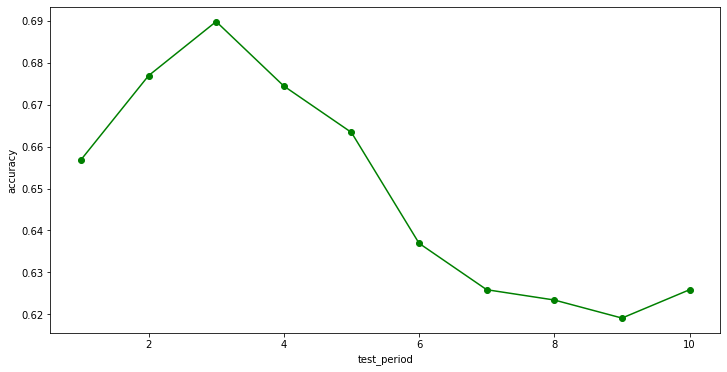

In [74]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], cv_res['test_accuracy'], "o-", color='green')

In [51]:
regr = xgb.XGBClassifier(n_jobs=3, disable_default_eval_metric=True, eval_metric='mphe')
metric_accuracy = make_scorer(my_accuracy)
cv_res = cross_validate(regr, X_train, y_train, scoring = {'accuracy': metric_accuracy}, return_train_score=True, cv=10)

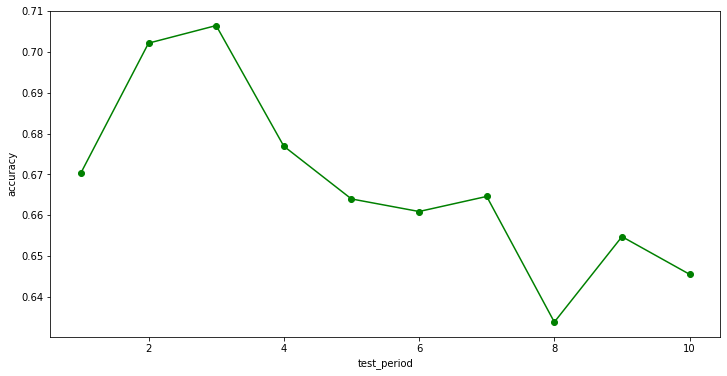

In [52]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], cv_res['test_accuracy'], "o-", color='green')

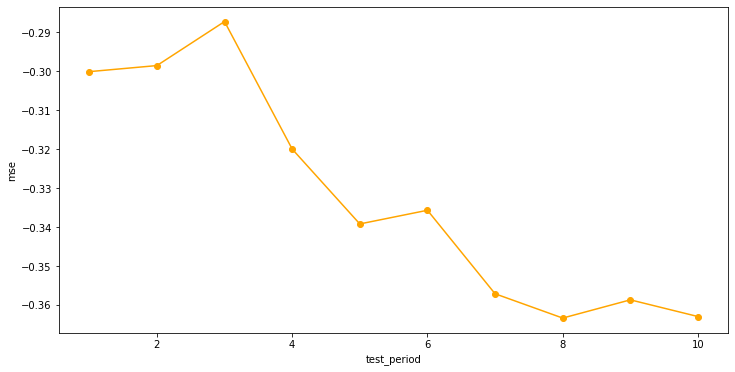

In [174]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("mse")
plt.plot([x for x in range(1, 11)], cv_res['test_mse'], "o-", color='orange')

## XGBRegressor

In [175]:
regr = xgb.XGBRegressor(n_jobs=3)
metric_accuracy = make_scorer(my_accuracy)
cv_res = cross_validate(regr, X_train, y_train, scoring = {'accuracy': metric_accuracy,
                                                          'mse': 'neg_mean_squared_error'}, return_train_score=True, cv=10)

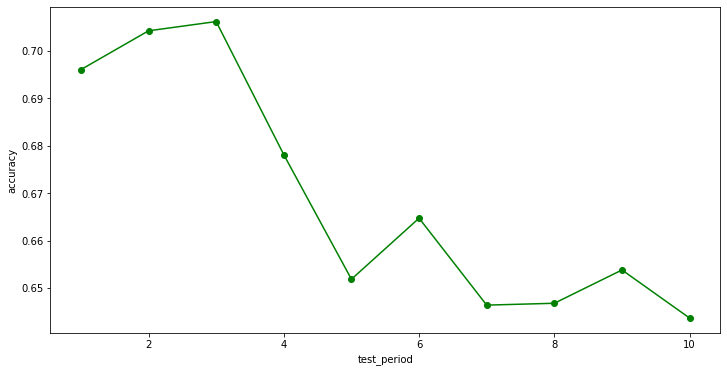

In [176]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], cv_res['test_accuracy'], "o-", color='green')

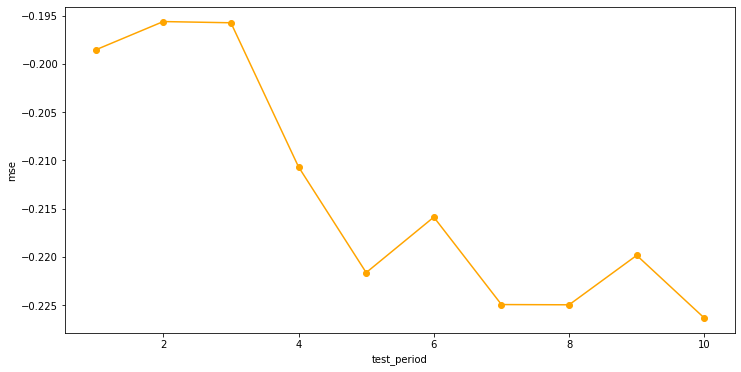

In [177]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("mse")
plt.plot([x for x in range(1, 11)], cv_res['test_mse'], "o-", color='orange')

## XGBClassifier

In [9]:
metric_accuracy = make_scorer(my_accuracy)
grid_params = {
    'learning_rate': [0.02, 0.04], 
    'max_depth': [2, 4],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'n_estimators': [70, 100, 150],
    'eval_metric': ['logloss']
}

# scoring = {'accuracy': metric_accuracy, 'mse': 'neg_mean_squared_error'}
cv = TimeSeriesSplit(n_splits=10)
gs_cl = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, scoring=my_accuracy, cv=cv, return_train_score=True)
gs_cl.fit(X_train,y_train, verbose=True)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weigh...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'colsample_bytree': [0.8, 0.9],
                    

In [13]:
gs_cl.cv_results_

{'mean_fit_time': array([  9.67704074,  10.10231194,  13.68149343,  15.57992561,
         19.54930923,  20.16544664,  20.09610593,  19.92479324,
         26.78912041,  27.26773453,  38.44955401,  37.15084589,
          9.95235739,  10.06367023,  12.95510349,  13.25090911,
         18.52018962,  18.74564064,  17.93739803,  18.31524591,
         24.45003657,  25.12135875,  35.32474597,  36.06333137,
         10.66429808,  10.65664611,  14.21873283,  14.5332427 ,
         20.48451385,  21.01477301, 202.70131888,  39.62903726,
         95.34926794, 110.23836286, 163.54626715, 174.55822303,
         41.93201222,  40.5856113 ,  55.46251037,  54.29927282,
         81.89763317,  89.14524961,  84.49631829,  81.87098072,
         30.60227671,  31.24790499,  52.69462883,  48.56633043]),
 'std_fit_time': array([  6.73745618,   7.34554293,  10.00251232,  11.09259093,
         13.83588209,  14.74733936,  14.73366447,  14.36539872,
         18.90070953,  18.32294773,  28.5689858 ,  27.35958813,
     

In [164]:
res_accuracy_cl = []
res_mse_cl = []
for x in range(10):
    res_accuracy_cl.append(gs_cl.cv_results_['split{0}_test_accuracy'.format(x)].mean())
    res_mse_cl.append(gs_cl.cv_results_['split{0}_test_mse'.format(x)].mean())

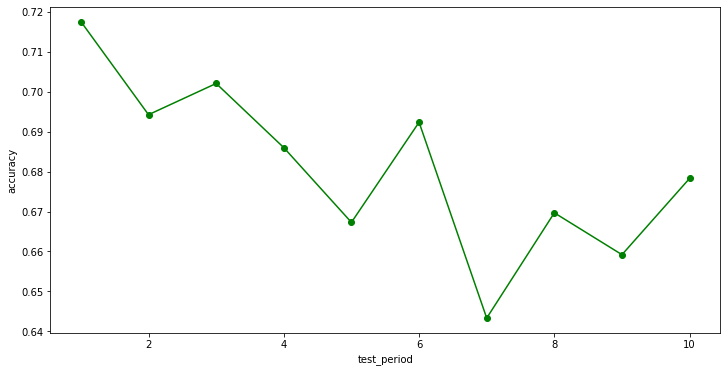

In [165]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], res_accuracy_cl, "o-", color='green')

In [181]:
np.array(res_accuracy_cl).mean()

0.6810177244139508

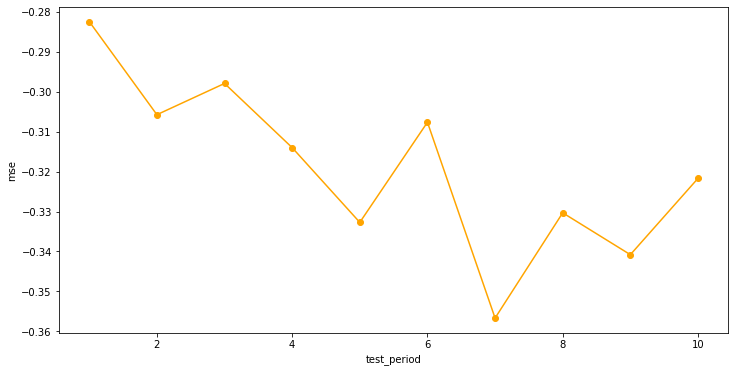

In [166]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("mse")
plt.plot([x for x in range(1, 11)], res_mse_cl, "o-", color='orange')

## XGBRegressor

In [13]:
metric_accuracy = make_scorer(my_accuracy)
grid_params = {
    'learning_rate': [0.01, 0.02], 
    'max_depth': [1, 2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8],
    'n_estimators': [150, 250]
}

scoring = {'accuracy': metric_accuracy, 'mse': 'neg_mean_squared_error'}
cv = TimeSeriesSplit(n_splits=10)
gs_reg = GridSearchCV(xgb.XGBRegressor(n_jobs=3), grid_params, cv=cv, scoring=scoring, return_train_score=True, refit=False)
gs_reg.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             param_grid={'colsample_bytree': [0.8],
                         'learning_r

In [155]:
res_accuracy = []
res_mse = []
for x in range(10):
    res_accuracy.append(gs_reg.cv_results_['split{0}_test_accuracy'.format(x)].mean())
    res_mse.append(gs_reg.cv_results_['split{0}_test_mse'.format(x)].mean())

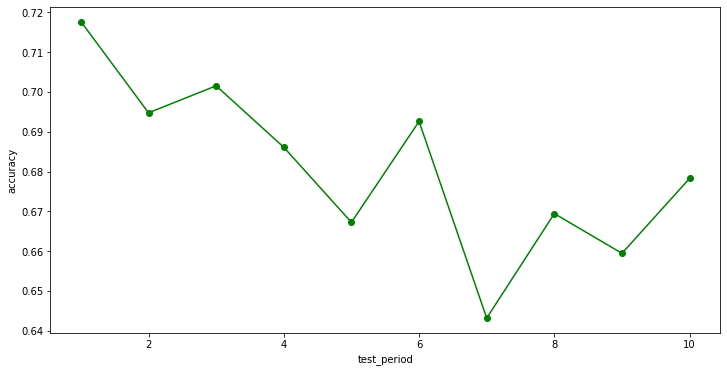

In [158]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], res_accuracy, "o-", color='green')

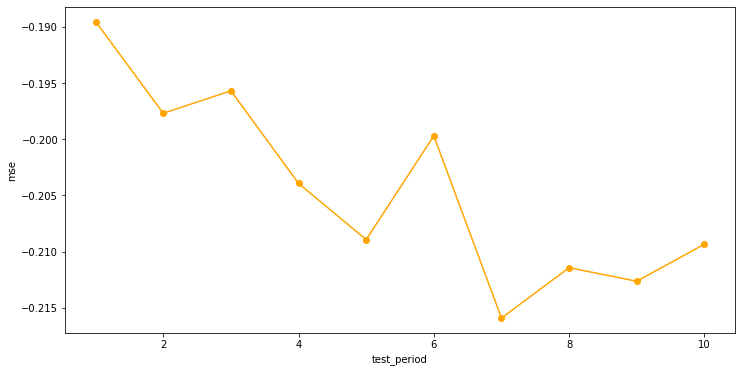

In [173]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("mse")
plt.plot([x for x in range(1, 11)], res_mse, "o-", color='orange')